<a href="https://colab.research.google.com/github/ziyuezhao1/ddpm/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 模型

In [ ]:
# no problem
import os
import math
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# 无需更改
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


In [ ]:
# 需要更改
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def p_sample_loop_new(self, model, image):
        # denoise: reverse diffusion
        batch_size = image.shape[0]
        device = next(model.parameters()).device
        img=image
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs


    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))



    def train_losses(self, model, x_start, t):
        # compute train losses
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

    def get_parameter(self, model, x_start, t):
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)

        predicted_noise = model(x_noisy, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_noisy, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all

    def get_parameter2(self, model, x_final, t,T):
        # get x_t
        noise = torch.randn_like(x_final)
        x_0=self.predict_start_from_noise(x_final, T, noise)
        x_t=self.q_sample(x_0, t, noise=noise)

        predicted_noise = model(x_t, t)

        alphas=self.alphas.to(t.device)
        betas=self.betas.to(t.device)

        sqrt_one_minus_alphas_cumprod=self.sqrt_one_minus_alphas_cumprod.to(t.device)
        mean1,variance_all,posterior_log_variance=self.p_mean_variance(model, x_t, t)

        #mean1=alphas[t]*x_noisy-predicted_noise*betas[t]/sqrt_one_minus_alphas_cumprod

        return mean1,variance_all


看看效果

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

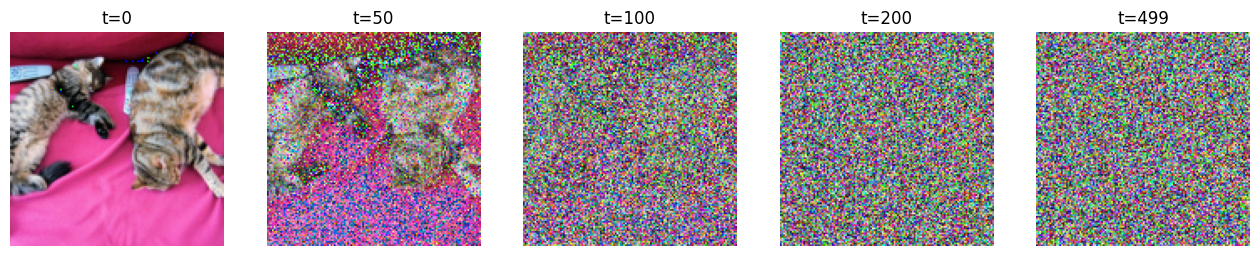

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

## 训练

准备数据集

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset,indices,label):
        self.original_dataset = original_dataset
        self.indices  = indices
        self.label = label

    def __getitem__(self, index):
        image, _ = self.original_dataset[self.indices[index]]
        return image, self.label

    def __len__(self):
        return len(self.indices)

In [ ]:
batch_size = 128
timesteps = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 186065202.24it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38962912.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 229428456.63it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 3916638.32it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
mnist_indices = [i for i in range(len(dataset)) if dataset[i][1] == 3]
mnist2_indices = [i for i in range(len(dataset)) if dataset[i][1] == 2]
dataset_image_number=5888
mnist_dataset = BinaryDataset(dataset, mnist_indices[0:dataset_image_number],label=3 )
mnist2_dataset = BinaryDataset(dataset, mnist2_indices[0:dataset_image_number],label=2 )

train_dataset = torch.utils.data.ConcatDataset([mnist_dataset, mnist2_dataset])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_dataset1 = torch.utils.data.ConcatDataset([mnist_dataset])
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)


train_dataset2 = torch.utils.data.ConcatDataset([mnist2_dataset])
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 3]
mnist2_indices_test = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 2]

mnist_dataset_test = BinaryDataset(test_dataset, mnist_indices_test,label=3 )
mnist_dataset_testmnist_dataset_test = BinaryDataset(test_dataset, mnist_indices_test,label=2 )

test_dataset = torch.utils.data.ConcatDataset([mnist_dataset_test, mnist_dataset_test])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])
torch.Size([1, 28, 28])


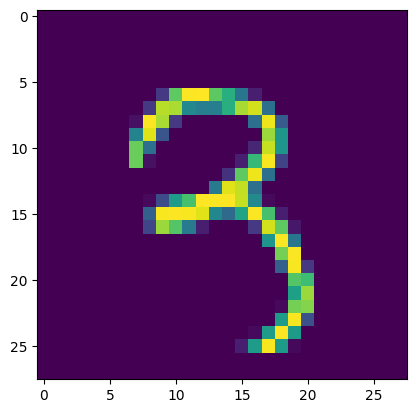

torch.Size([28, 28])


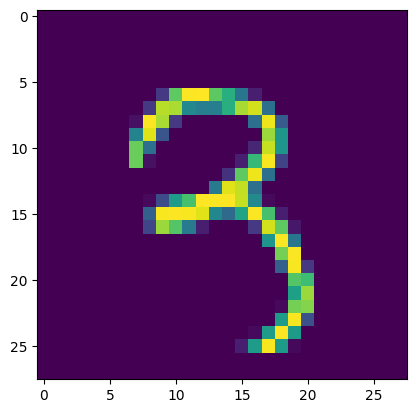

Label: 3


In [ ]:
train_features, train_labels = next(iter(train_loader1))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1]
label = train_labels[0]
print(img.size())
plt.imshow(torch.permute(img, (1,2,0)))
plt.show()
img1=torch.squeeze(img)
print(img1.size())
plt.imshow(torch.permute(img1, (0, 1)))
plt.show()
print(f"Label: {label}")

模型

开始训练

In [ ]:
import torch,gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)

In [ ]:
epochs = 10
steps=int(dataset_image_number/batch_size)
print(steps)
loss_average=torch.zeros([epochs,steps])
for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader1):
        optimizer.zero_grad()

        batch_size = images.shape[0]
        images1 = images.to(device)

        images2,labels2=next(iter(train_loader2))
        imagesnew = images2.to(device)

        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        T=torch.full((batch_size,),timesteps-1, device=device)

        mean1,variance1 = gaussian_diffusion.get_parameter2(model, images1,t,T)
        mean2,variance2 = gaussian_diffusion.get_parameter2(model, imagesnew,t,T)

        loss=torch.zeros([batch_size])

        for i in range(0,batch_size):
          sigma=torch.eye(images.shape[2]).to(variance1.device)
          sigma_inverse=torch.inverse(sigma*(variance1[i].item()+1e-8))
          cha=mean1[i,0,:,:]-mean2[i,0,:,:]
          loss[i]=torch.mean(-cha@sigma_inverse@cha.transpose(0,1))
        loss_batch_average=torch.mean(loss)
        loss_average[epoch,step]=loss_batch_average

        if step%10 == 0:
            print("Loss_batch_average:","epoch",epoch,"step",step,loss_batch_average)
        loss_batch_average.requires_grad_(True)

        loss_batch_average.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10, norm_type=2)
        optimizer.step()

46
Loss_batch_average: epoch 0 step 0 tensor(-7490051., grad_fn=<MeanBackward0>)
Loss:out of 200 tensor(-7490051., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 1 tensor(-5190142., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 2 tensor(-5825974., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 3 tensor(-5457980.5000, grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 4 tensor(-6731166., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 5 tensor(-3676016., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 6 tensor(-2939089.2500, grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 7 tensor(-1869757.1250, grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 8 tensor(-7741118., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 9 tensor(-1902232.2500, grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 10 tensor(-5005681., grad_fn=<MeanBackward0>)
Loss_batch_average: epoch 0 step 11 tensor(-5563793.5000, grad_

tensor([-4922923., -4742120., -5094003., -4887004., -5161463., -4492620.,
        -4652473., -4062607., -4807582., -4780948.], grad_fn=<MeanBackward1>)


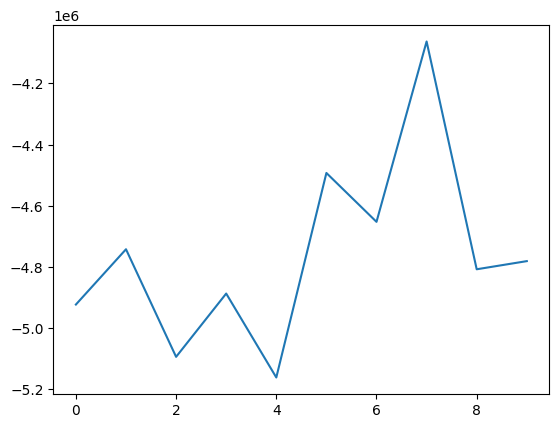

In [ ]:
epochs_list=[i for i in range(0,epochs)]
print(loss_average.mean(1))
plt.figure()
plt.plot(epochs_list,loss_average.mean(1).detach().numpy())
plt.show()

## 测试

In [ ]:
batch_size=1
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=1, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=1, shuffle=True)
T=torch.full((batch_size,),timesteps-1, device=device)
steps=int(dataset_image_number/batch_size)
print(steps)
x_1=torch.zeros([steps,1,28,28])
x_2=torch.zeros([steps,1,28,28])
for step, (images, labels) in enumerate(train_loader1):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    predicted_noise = model(images, T)
    x_1[step,0,:,:]=gaussian_diffusion.predict_start_from_noise(images, T, predicted_noise)
x_1_general=x_1.mean(0)
print(x_1_general.shape)
print(x_1.shape)
for step, (images, labels) in enumerate(train_loader2):
  with torch.no_grad():
    batch_size = images.shape[0]
    images = images.to(device)
    predicted_noise = model(images, T)
    x_2[step,0,:,:]=gaussian_diffusion.predict_start_from_noise(images, T, predicted_noise)
x_2_general=x_2.mean(0)

5888
torch.Size([1, 28, 28])
torch.Size([5888, 1, 28, 28])


In [ ]:
pred_labels=torch.zeros(len(test_dataset))
accuaracy=0
for step, (image, label) in enumerate(test_loader):
  batch_size = image.shape[0]
  image = image.to(device)
  predicted_noise = model(image, T)
  x_0=gaussian_diffusion.predict_start_from_noise(image, T, predicted_noise).to(device)
  a=torch.norm(x_0[0]-x_1_general.to(device)).to(device)
  b=torch.norm(x_0[0]-x_2_general.to(device)).to(device)
  if a >= b:
    pred_label= 2
  else:
    pred_label= 3
  if pred_label==label:
    accuaracy=accuaracy+1


In [ ]:
print(accuaracy/len(test_dataset))

0.9207920792079208
